'\n解释 for i, (ax, img) in enumerate(zip(axes, imgs)):\n\n例如 axes = [ax1,ax2,ax3] imgs = [img1,img2,img3]\nzip返回 (ax1,img1),(ax2,img2),(ax3,img3)\nenumerate为每个配对添加索引\n返回 (0,(ax1,img1)),(1,(ax2,img2)),(2,(ax3,img3))\n\naxes中是各个ax，其中包含各个子图的绘制方法，位置，尺寸大小\nimg就是各张图片具体的像素，用来显示的信息。\n'

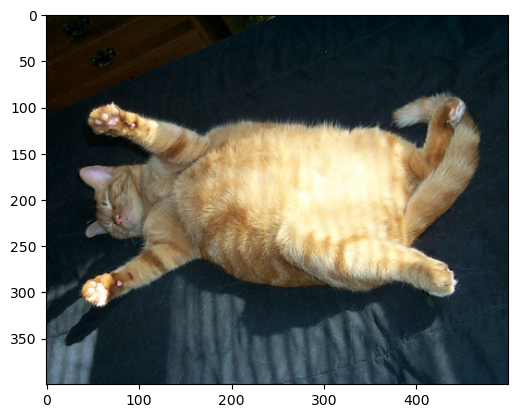

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决运行时内核崩溃

# %matplotlib inline
import torch
import torchvision
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from d2l import torch as d2l

img = Image.open('./img/cat1.jpg')
plt.imshow(img)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()
'''
解释 for i, (ax, img) in enumerate(zip(axes, imgs)):

例如 axes = [ax1,ax2,ax3] imgs = [img1,img2,img3]
zip返回 (ax1,img1),(ax2,img2),(ax3,img3)
enumerate为每个配对添加索引
返回 (0,(ax1,img1)),(1,(ax2,img2)),(2,(ax3,img3))

axes中是各个ax，其中包含各个子图的绘制方法，位置，尺寸大小
img就是各张图片具体的像素，用来显示的信息。
'''

In [2]:
def apply(img,aug,num_rows = 2,num_cols = 4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y,num_rows,num_cols,scale=scale)

**左右翻转图像**

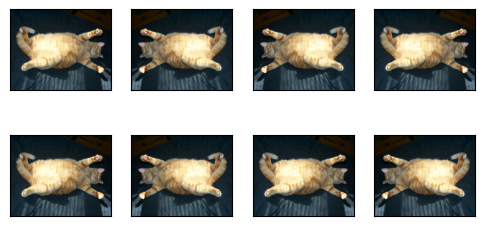

In [3]:
apply(img,torchvision.transforms.RandomHorizontalFlip())

**上下翻转图像**

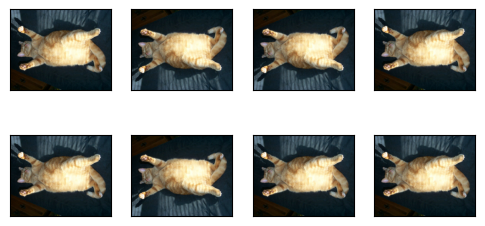

In [4]:
apply(img,torchvision.transforms.RandomVerticalFlip())

**随机剪裁**

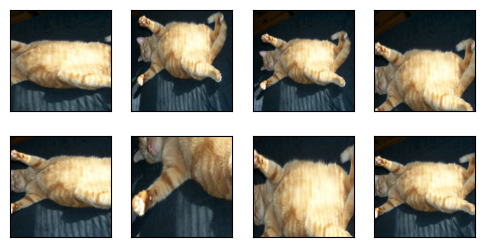

In [5]:
'''最后输出的尺寸是200x200 裁剪的部分尺寸占原始图片的10%到100%  高宽比0.5到2'''
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200,200), scale = (0.1,1), ratio=(0.5,2))
apply(img, shape_aug)

**随机更改图像的亮度**

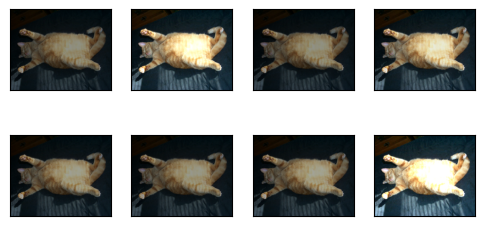

In [6]:
'''
四个参数分别是 亮度 对比度 饱和度 色调
0.5意味着在[-50%,50%]范围内改变
0意味着不改变
'''
apply(img,torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

**随机更改图像的色调**

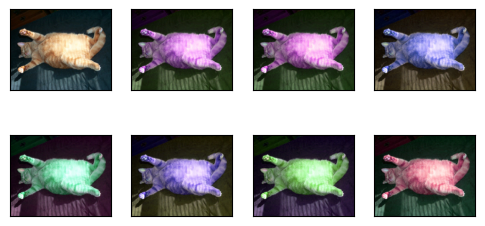

In [7]:
apply(img,torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

**随机更改图像的亮度(brightness)、对比度(contrast)、饱和度(saturation)和色调(hue)**

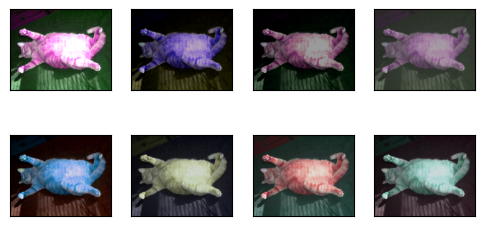

In [8]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img,color_aug)

**结合多种图像增广方法**

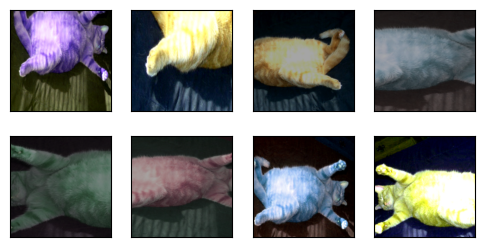

In [9]:
'''随机水平翻转 改变亮度对比度饱和度色调 再随机裁剪'''
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug,shape_aug])
apply(img,augs)

**使用图像增广进行训练**

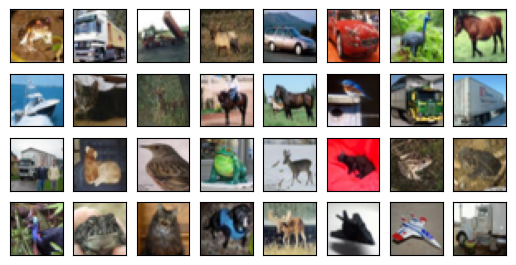

In [10]:
all_images = torchvision.datasets.CIFAR10(
    train = True, root = "../data" ,download = True)
show_images([
    all_images[i][0] for i in range(32)],4,8,scale=0.8)

只使用最简单的随机左右翻转

In [11]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])#RGB值都类型转换为float32再除以255

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

**定义一个辅助函数，以便于读取图像和应用图像增广**

In [12]:
'''
调用CIFAR10的时候传入augs,每次读数据的时候都会应用augs
数据增广计算量不小，很多时候可能是计算瓶颈
'''
def load_cifar10(is_train,augs,batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root = "../data",train=is_train,
        transform=augs,download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset,batch_size=batch_size,shuffle=is_train,
        num_workers=0)
    return dataloader

**定义一个函数，使用多GPU对模型进行训练和评估**

In [13]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X] # 如果X是一个list，则把数据一个接一个都挪到devices[0]上    
    else:
        X = X.to(devices[0]) # 如果X不是一个list，则把X挪到devices[0]上
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],
                           legend=['train loss', 'train acc', 'test acc'])
    # nn.DataParallel使用多GPU
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net,features,labels,loss,trainer,devices)   
            metric.add(l,acc,labels.shape[0],labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches -1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))              
        test_acc = d2l.evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc'
         f' {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f' {metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
         f' {str(devices)}')  

**定义`trian_with_data_aug`函数，使用图像增广来训练模型**

loss 0.171, train acc 0.941, test acc 0.821
 1282.1 examples/sec on  [device(type='cuda', index=0)]


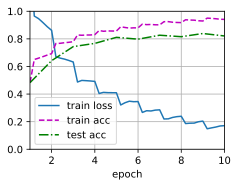

In [14]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10,3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)
        
net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    # Adam优化器算是一个比较平滑的SGD，它对学习率调参不是很敏感
    trainer = torch.optim.Adam(net.parameters(),lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)
    
train_with_data_aug(train_augs, test_augs, net)